In [1]:
# install wandb
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 14.5 MB/s 
     |████████████████████████████████| 182 kB 54.9 MB/s 
     |████████████████████████████████| 168 kB 68.5 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 166 kB 56.8 MB/s 
     |████████████████████████████████| 166 kB 46.8 MB/s 
     |████████████████████████████████| 162 kB 21.5 MB/s 
     |████████████████████████████████| 162 kB 57.3 MB/s 
     |████████████████████████████████| 158 kB 62.3 MB/s 
     |████████████████████████████████| 157 kB 54.3 MB/s 
     |████████████████████████████████| 157 kB 14.7 MB/s 
     |████████████████████████████████| 157 kB 79.5 MB/s 
     |████████████████████████████████| 157 kB 51.4 MB/s 
     |████████████████████████████████| 157 kB 52.1 MB/s 
     |████████████████████████████████| 157 kB 11.6 MB/s 
     |████████████████████████████████| 157 kB 56.4 MB/s 
     |████████████████████████████████| 156 kB 58.2 MB/s 


In [2]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 28.2 MB/s 
     |████████████████████████████████| 66 kB 5.9 MB/s 
     |████████████████████████████████| 46 kB 5.4 MB/s 


In [3]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
import wandb
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
from codecarbon import EmissionsTracker

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

In [6]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "transfer_learning_VGG-16",
  "artifact_name": "animals_raw_data:latest"
}

In [7]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="gildson",project=args["project_name"], job_type="transfer_learning")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

wandb: Currently logged in as: gildson. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact animals_raw_data:latest, 94.21MB. 950 files... 
wandb:   950 of 950 files downloaded.  
Done. 0:0:33.0
22-11-2022 00:48:30 Path: ./artifacts/animals_raw_data:v0


In [8]:
run.finish()

In [9]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "transfer_learning_ResNet50"
}

In [10]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="gildson",project=args["project_name"], job_type="transfer_learning")

In [11]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

raw_wb = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical')

Found 950 files belonging to 5 classes.


In [12]:
# 80% train, 20% validation and test
all_batches = tf.data.experimental.cardinality(raw_wb)
valtest_dataset = raw_wb.take(all_batches // 5)
train_dataset = raw_wb.skip(all_batches // 5)

valtest_batches = tf.data.experimental.cardinality(valtest_dataset)
test_dataset = valtest_dataset.take(valtest_batches // 5)
validation_dataset = valtest_dataset.skip(valtest_batches // 5)

In [13]:
print('Number of raw batches: %d' % tf.data.experimental.cardinality(raw_wb))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of raw batches: 30
Number of train batches: 24
Number of validation batches: 5
Number of test batches: 1


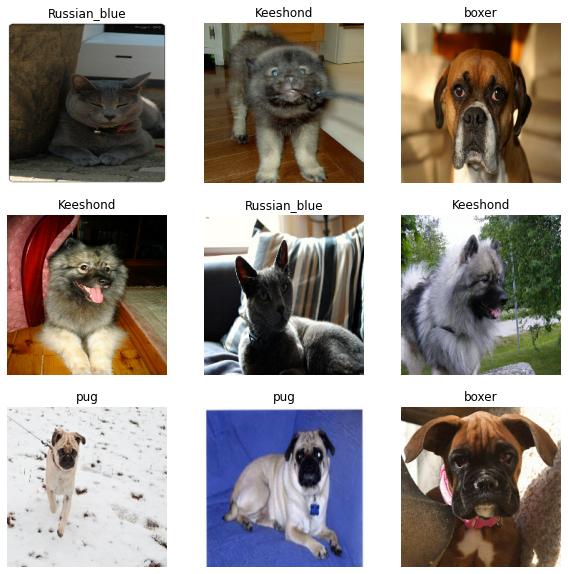

In [14]:
class_names = raw_wb.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

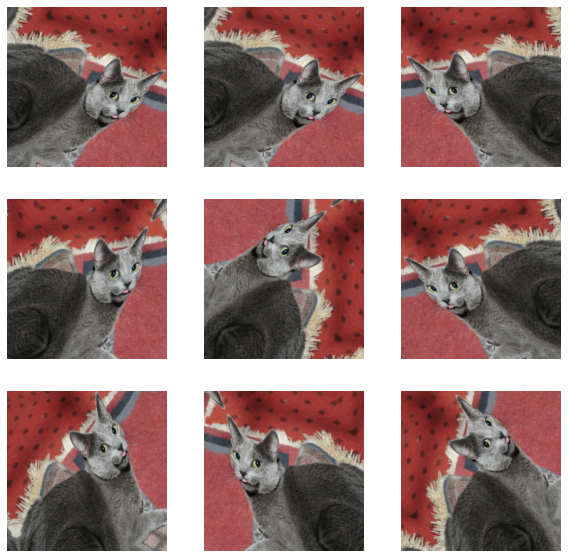

In [17]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Transfer learning with feature extractor

In [18]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

94765736/94765736 [==============================] - 5s 0us/step


In [19]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [20]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [21]:
model.trainable = False

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [23]:
n_classes=5
prediction_layer = tf.keras.layers.Dense(n_classes,"softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [24]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    callbacks=[wandb.keras.WandbCallback(save_model=True,
                                                   compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
22-11-2022 00:51:14 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5254: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 1.8985 - accuracy: 0.2375

22-11-2022 00:51:43 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:51:48 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 0.9s


24/24 [==============================] - 35s 1s/step - loss: 1.8985 - accuracy: 0.2375 - val_loss: 1.3827 - val_accuracy: 0.4437
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 1.4021 - accuracy: 0.4261

22-11-2022 00:52:12 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:52:17 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 0.9s


24/24 [==============================] - 29s 1s/step - loss: 1.4021 - accuracy: 0.4261 - val_loss: 0.9907 - val_accuracy: 0.6562
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 1.0856 - accuracy: 0.5699

22-11-2022 00:52:53 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:52:57 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.0s


24/24 [==============================] - 28s 1s/step - loss: 1.0856 - accuracy: 0.5699 - val_loss: 0.7483 - val_accuracy: 0.7812
Epoch 4/20
24/24 [==============================] - ETA: 0s - loss: 0.8667 - accuracy: 0.7084

22-11-2022 00:53:24 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:53:28 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.0s


24/24 [==============================] - 31s 1s/step - loss: 0.8667 - accuracy: 0.7084 - val_loss: 0.5587 - val_accuracy: 0.8500
Epoch 5/20
24/24 [==============================] - ETA: 0s - loss: 0.7129 - accuracy: 0.7757

22-11-2022 00:53:53 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:53:58 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.0s


24/24 [==============================] - 30s 1s/step - loss: 0.7129 - accuracy: 0.7757 - val_loss: 0.4548 - val_accuracy: 0.8875
Epoch 6/20
24/24 [==============================] - ETA: 0s - loss: 0.5495 - accuracy: 0.8602

22-11-2022 00:54:22 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:54:27 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.0s


24/24 [==============================] - 29s 1s/step - loss: 0.5495 - accuracy: 0.8602 - val_loss: 0.3621 - val_accuracy: 0.9187
Epoch 7/20
24/24 [==============================] - ETA: 0s - loss: 0.4809 - accuracy: 0.8734

22-11-2022 00:54:52 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:54:57 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.0s


24/24 [==============================] - 30s 1s/step - loss: 0.4809 - accuracy: 0.8734 - val_loss: 0.2984 - val_accuracy: 0.9500
Epoch 8/20
24/24 [==============================] - ETA: 0s - loss: 0.3917 - accuracy: 0.9011

22-11-2022 00:55:32 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:55:37 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 0.8s


24/24 [==============================] - 30s 1s/step - loss: 0.3917 - accuracy: 0.9011 - val_loss: 0.2444 - val_accuracy: 0.9625
Epoch 9/20
24/24 [==============================] - ETA: 0s - loss: 0.3744 - accuracy: 0.9063

22-11-2022 00:56:13 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:56:17 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 0.9s


24/24 [==============================] - 29s 1s/step - loss: 0.3744 - accuracy: 0.9063 - val_loss: 0.2331 - val_accuracy: 0.9688
Epoch 10/20
24/24 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.9314

22-11-2022 00:56:43 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:56:48 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 0.9s


24/24 [==============================] - 31s 1s/step - loss: 0.3139 - accuracy: 0.9314 - val_loss: 0.1903 - val_accuracy: 0.9812
Epoch 11/20
24/24 [==============================] - ETA: 0s - loss: 0.2799 - accuracy: 0.9354

22-11-2022 00:57:23 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:57:27 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 0.8s


24/24 [==============================] - 29s 1s/step - loss: 0.2799 - accuracy: 0.9354 - val_loss: 0.1821 - val_accuracy: 0.9750
Epoch 12/20
24/24 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.9459

22-11-2022 00:58:04 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:58:09 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 0.8s


24/24 [==============================] - 29s 1s/step - loss: 0.2646 - accuracy: 0.9459 - val_loss: 0.1668 - val_accuracy: 0.9750
Epoch 13/20
24/24 [==============================] - ETA: 0s - loss: 0.2376 - accuracy: 0.9631

22-11-2022 00:58:33 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:58:37 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 0.8s


24/24 [==============================] - 29s 1s/step - loss: 0.2376 - accuracy: 0.9631 - val_loss: 0.1317 - val_accuracy: 0.9937
Epoch 14/20
24/24 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.9459

22-11-2022 00:59:14 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:59:18 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 0.7s


24/24 [==============================] - 29s 1s/step - loss: 0.2348 - accuracy: 0.9459 - val_loss: 0.1300 - val_accuracy: 0.9875
Epoch 15/20
24/24 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9578

22-11-2022 00:59:44 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 00:59:48 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 0.9s


24/24 [==============================] - 30s 1s/step - loss: 0.2118 - accuracy: 0.9578 - val_loss: 0.1198 - val_accuracy: 0.9812
Epoch 16/20
24/24 [==============================] - 5s 185ms/step - loss: 0.2077 - accuracy: 0.9459 - val_loss: 0.1331 - val_accuracy: 0.9875
Epoch 17/20
24/24 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.9538

22-11-2022 01:00:35 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 01:00:39 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 0.9s


24/24 [==============================] - 30s 1s/step - loss: 0.1876 - accuracy: 0.9538 - val_loss: 0.0902 - val_accuracy: 0.9937
Epoch 18/20
24/24 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9697

22-11-2022 01:01:15 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 01:01:19 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 0.9s


24/24 [==============================] - 29s 1s/step - loss: 0.1583 - accuracy: 0.9697 - val_loss: 0.0900 - val_accuracy: 1.0000
Epoch 19/20
24/24 [==============================] - 5s 186ms/step - loss: 0.1728 - accuracy: 0.9459 - val_loss: 0.0968 - val_accuracy: 0.9875
Epoch 20/20
24/24 [==============================] - 5s 186ms/step - loss: 0.1358 - accuracy: 0.9736 - val_loss: 0.0970 - val_accuracy: 0.9812


In [26]:
# number of parameters
run.summary["Count_Params of the transfer learning with feature extractor"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed of the transfer learning with feature extractor"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM of the transfer learning with feature extractor"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU of the transfer learning with feature extractor"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU of the transfer learning with feature extractor"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions of the transfer learning with feature extractor"] = tracker.final_emissions_data.emissions

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

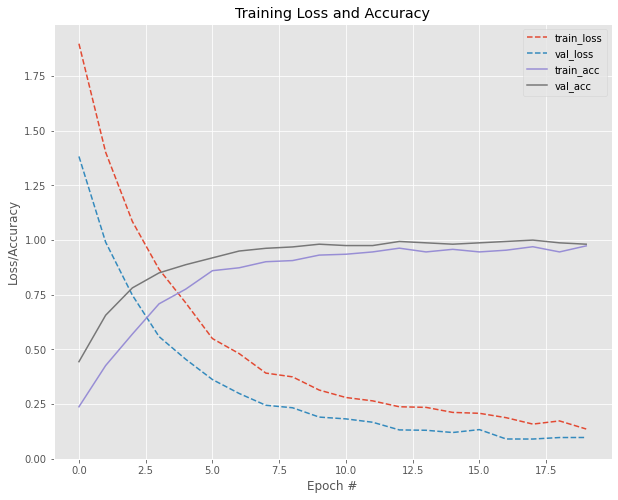

In [28]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [29]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "Training Loss and Accuracy of the transfer learning with feature extractor": wandb.Image(fig),
    }
)

22-11-2022 01:02:12 Uploading figures


In [30]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y2 = np.concatenate([y for x, y in test_dataset], axis=0)

In [31]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [32]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
1/1 [==============================] - 1s 903ms/step
              precision    recall  f1-score   support

      Bengal       1.00      1.00      1.00         6
    Keeshond       1.00      1.00      1.00         9
Russian_blue       1.00      1.00      1.00         5
       boxer       1.00      1.00      1.00         7
         pug       1.00      1.00      1.00         5

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



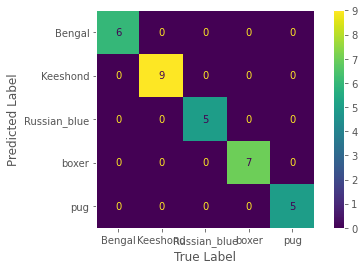

In [33]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [34]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix of the transfer learning with feature extractor": wandb.Image(fig_confusion_matrix),
    }
)

22-11-2022 01:02:44 Uploading figures


Transfer Learning with fine tuning

In [35]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50

# whether or not to include top of CNN
include_top = 0

# load the VGG16 network
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top= include_top > 0)
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] loading network...
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	ZeroPadding2D
[INFO] 2	Conv2D
[INFO] 3	BatchNormalization
[INFO] 4	Activation
[INFO] 5	ZeroPadding2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	Activation
[INFO] 10	Conv2D
[INFO] 11	BatchNormalization
[INFO] 12	Activation
[INFO] 13	Conv2D
[INFO] 14	Conv2D
[INFO] 15	BatchNormalization
[INFO] 16	BatchNormalization
[INFO] 17	Add
[INFO] 18	Activation
[INFO] 19	Conv2D
[INFO] 20	BatchNormalization
[INFO] 21	Activation
[INFO] 22	Conv2D
[INFO] 23	BatchNormalization
[INFO] 24	Activation
[INFO] 25	Conv2D
[INFO] 26	BatchNormalization
[INFO] 27	Add
[INFO] 28	Activation
[INFO] 29	Conv2D
[INFO] 30	BatchNormalization
[INFO] 31	Activation
[INFO] 32	Conv2D
[INFO] 33	BatchNormalization
[INFO] 34	Activation
[INFO] 35	Conv2D
[INFO] 36	BatchNormalization
[INFO] 37	Add
[INFO] 38	Activation
[INFO] 39	Conv2D
[INFO] 40	BatchNormalization
[INFO] 41	Activation
[INFO] 42	Conv2D
[INFO] 43	BatchNormalizat

In [36]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, neurons):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(neurons, activation="relu")(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

In [38]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [39]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
outputs = base_model(x, training=False)
base_model = tf.keras.Model(inputs, outputs)

In [40]:
base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-t

In [41]:
# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(base_model, len(class_names), 256)

In [42]:
# place the head FC model on top of the base model -- this will
# become the actual model we will train
model = Model(inputs=base_model.input, outputs=headModel)

In [43]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0   

In [44]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [45]:
# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in model.layers[4].layers:
	layer.trainable = False


In [46]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0   

In [47]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# RMSprop is frequently used in situations where we need to quickly obtain
# reasonable performance (as is the case when we are trying to “warm up” a set of FC layers).
opt = RMSprop(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    callbacks=[wandb.keras.WandbCallback(save_model=True,
                                                   compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] training head...
Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 2.2744 - accuracy: 0.7625

22-11-2022 01:04:13 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 01:04:18 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 2.0s


24/24 [==============================] - 35s 1s/step - loss: 2.2744 - accuracy: 0.7625 - val_loss: 0.0211 - val_accuracy: 0.9937
Epoch 2/20
24/24 [==============================] - 6s 197ms/step - loss: 0.2646 - accuracy: 0.9512 - val_loss: 0.0745 - val_accuracy: 0.9812
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.9591

22-11-2022 01:04:51 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 01:04:56 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 2.0s


24/24 [==============================] - 32s 1s/step - loss: 0.1700 - accuracy: 0.9591 - val_loss: 0.0142 - val_accuracy: 0.9937
Epoch 4/20
24/24 [==============================] - 6s 197ms/step - loss: 0.1311 - accuracy: 0.9723 - val_loss: 0.0812 - val_accuracy: 0.9937
Epoch 5/20
24/24 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9631

22-11-2022 01:05:29 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 01:05:34 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.9s


24/24 [==============================] - 32s 1s/step - loss: 0.1832 - accuracy: 0.9631 - val_loss: 0.0114 - val_accuracy: 0.9937
Epoch 6/20
24/24 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9736

22-11-2022 01:06:01 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 01:06:06 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.9s


24/24 [==============================] - 35s 1s/step - loss: 0.1390 - accuracy: 0.9736 - val_loss: 4.7357e-04 - val_accuracy: 1.0000
Epoch 7/20
24/24 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 0.9763

22-11-2022 01:06:42 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 01:06:47 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.8s


24/24 [==============================] - 32s 1s/step - loss: 0.1025 - accuracy: 0.9763 - val_loss: 1.0221e-05 - val_accuracy: 1.0000
Epoch 8/20
24/24 [==============================] - 6s 199ms/step - loss: 0.0812 - accuracy: 0.9894 - val_loss: 7.0026e-04 - val_accuracy: 1.0000
Epoch 9/20
24/24 [==============================] - 6s 198ms/step - loss: 0.1757 - accuracy: 0.9736 - val_loss: 0.0174 - val_accuracy: 0.9937
Epoch 10/20
24/24 [==============================] - 6s 193ms/step - loss: 0.0726 - accuracy: 0.9868 - val_loss: 1.3511e-05 - val_accuracy: 1.0000
Epoch 11/20
24/24 [==============================] - 6s 197ms/step - loss: 0.0787 - accuracy: 0.9855 - val_loss: 0.0182 - val_accuracy: 0.9937
Epoch 12/20
24/24 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9868

22-11-2022 01:07:40 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 01:07:45 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.8s


24/24 [==============================] - 31s 1s/step - loss: 0.0555 - accuracy: 0.9868 - val_loss: 1.0333e-06 - val_accuracy: 1.0000
Epoch 13/20
24/24 [==============================] - 6s 194ms/step - loss: 0.0770 - accuracy: 0.9828 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 14/20
24/24 [==============================] - 6s 193ms/step - loss: 0.0703 - accuracy: 0.9894 - val_loss: 6.5513e-06 - val_accuracy: 1.0000
Epoch 15/20
24/24 [==============================] - 6s 193ms/step - loss: 0.0847 - accuracy: 0.9934 - val_loss: 1.8631e-06 - val_accuracy: 1.0000
Epoch 16/20
24/24 [==============================] - 6s 194ms/step - loss: 0.0593 - accuracy: 0.9868 - val_loss: 2.9053e-04 - val_accuracy: 1.0000
Epoch 17/20
24/24 [==============================] - 6s 232ms/step - loss: 0.0941 - accuracy: 0.9894 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 18/20
24/24 [==============================] - 6s 196ms/step - loss: 0.0765 - accuracy: 0.9815 - val_loss: 5.1838e-06 - val_accuracy: 

In [48]:
# number of parameters
run.summary["Count_Params of the transfer learning with fine tuning (head)"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed of the transfer learning with fine tuning (head)"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM of the transfer learning with fine tuning (head)"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU of the transfer learning with fine tuning (head)"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU "] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions of the transfer learning with fine tuning (head)"] = tracker.final_emissions_data.emissions

In [49]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [50]:
# loop over the layers in the base model network and display them to the
# console
for (i, layer) in enumerate(model.layers[4].layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	ZeroPadding2D
[INFO] 2	Conv2D
[INFO] 3	BatchNormalization
[INFO] 4	Activation
[INFO] 5	ZeroPadding2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	Activation
[INFO] 10	Conv2D
[INFO] 11	BatchNormalization
[INFO] 12	Activation
[INFO] 13	Conv2D
[INFO] 14	Conv2D
[INFO] 15	BatchNormalization
[INFO] 16	BatchNormalization
[INFO] 17	Add
[INFO] 18	Activation
[INFO] 19	Conv2D
[INFO] 20	BatchNormalization
[INFO] 21	Activation
[INFO] 22	Conv2D
[INFO] 23	BatchNormalization
[INFO] 24	Activation
[INFO] 25	Conv2D
[INFO] 26	BatchNormalization
[INFO] 27	Add
[INFO] 28	Activation
[INFO] 29	Conv2D
[INFO] 30	BatchNormalization
[INFO] 31	Activation
[INFO] 32	Conv2D
[INFO] 33	BatchNormalization
[INFO] 34	Activation
[INFO] 35	Conv2D
[INFO] 36	BatchNormalization
[INFO] 37	Add
[INFO] 38	Activation
[INFO] 39	Conv2D
[INFO] 40	BatchNormalization
[INFO] 41	Activation
[INFO] 42	Conv2D
[INFO] 43	BatchNormalization
[INFO] 44	Activation
[INFO] 45	Conv2D
[INFO] 46

In [51]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0   

In [52]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in model.layers[4].layers[15:]:
	layer.trainable = True

In [53]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0   

In [54]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    callbacks=[wandb.keras.WandbCallback(save_model=True,
                                                   compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] re-compiling model...
[INFO] training head...
Epoch 1/20
24/24 [==============================] - 19s 484ms/step - loss: 0.0295 - accuracy: 0.9934 - val_loss: 5.5147e-06 - val_accuracy: 1.0000
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9947

22-11-2022 01:10:57 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 01:11:02 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.2s


24/24 [==============================] - 35s 1s/step - loss: 0.0207 - accuracy: 0.9947 - val_loss: 6.9734e-07 - val_accuracy: 1.0000
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9947

22-11-2022 01:11:32 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 01:11:37 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.2s


24/24 [==============================] - 35s 1s/step - loss: 0.0671 - accuracy: 0.9947 - val_loss: 2.2798e-07 - val_accuracy: 1.0000
Epoch 4/20
24/24 [==============================] - 11s 421ms/step - loss: 0.0164 - accuracy: 0.9974 - val_loss: 1.6233e-06 - val_accuracy: 1.0000
Epoch 5/20
24/24 [==============================] - 11s 401ms/step - loss: 0.0168 - accuracy: 0.9947 - val_loss: 5.0749e-06 - val_accuracy: 1.0000
Epoch 6/20
24/24 [==============================] - 11s 403ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 9.1841e-06 - val_accuracy: 1.0000
Epoch 7/20
24/24 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9974

22-11-2022 01:12:46 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 01:12:52 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.2s


24/24 [==============================] - 36s 2s/step - loss: 0.0102 - accuracy: 0.9974 - val_loss: 5.0664e-08 - val_accuracy: 1.0000
Epoch 8/20
24/24 [==============================] - 10s 394ms/step - loss: 0.0029 - accuracy: 0.9987 - val_loss: 1.8072e-06 - val_accuracy: 1.0000
Epoch 9/20
24/24 [==============================] - 10s 397ms/step - loss: 0.0151 - accuracy: 0.9987 - val_loss: 1.5726e-06 - val_accuracy: 1.0000
Epoch 10/20
24/24 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9960

22-11-2022 01:13:45 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 01:13:49 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.2s


24/24 [==============================] - 37s 2s/step - loss: 0.0049 - accuracy: 0.9960 - val_loss: 2.6077e-08 - val_accuracy: 1.0000
Epoch 11/20
24/24 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9947

22-11-2022 01:14:24 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 01:14:29 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.3s


24/24 [==============================] - 36s 2s/step - loss: 0.0270 - accuracy: 0.9947 - val_loss: 2.9802e-09 - val_accuracy: 1.0000
Epoch 12/20
24/24 [==============================] - 11s 400ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 9.0896e-08 - val_accuracy: 1.0000
Epoch 13/20
24/24 [==============================] - 11s 403ms/step - loss: 0.0189 - accuracy: 0.9974 - val_loss: 6.5829e-06 - val_accuracy: 1.0000
Epoch 14/20
24/24 [==============================] - 11s 408ms/step - loss: 0.0048 - accuracy: 0.9974 - val_loss: 5.0792e-06 - val_accuracy: 1.0000
Epoch 15/20
24/24 [==============================] - 11s 394ms/step - loss: 0.0107 - accuracy: 0.9987 - val_loss: 2.9057e-08 - val_accuracy: 1.0000
Epoch 16/20
24/24 [==============================] - 10s 395ms/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 3.5091e-07 - val_accuracy: 1.0000
Epoch 17/20
24/24 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9987

22-11-2022 01:16:28 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callable after loading.
22-11-2022 01:16:33 Assets written to: /content/wandb/run-20221122_004915-126obmfh/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_004915-126obmfh/files/model-best)... Done. 1.3s


24/24 [==============================] - 36s 2s/step - loss: 0.0111 - accuracy: 0.9987 - val_loss: 7.4506e-10 - val_accuracy: 1.0000
Epoch 18/20
24/24 [==============================] - 11s 401ms/step - loss: 0.0328 - accuracy: 0.9960 - val_loss: 6.6310e-08 - val_accuracy: 1.0000
Epoch 19/20
24/24 [==============================] - 11s 406ms/step - loss: 0.0288 - accuracy: 0.9960 - val_loss: 1.7136e-08 - val_accuracy: 1.0000
Epoch 20/20
24/24 [==============================] - 11s 401ms/step - loss: 0.0157 - accuracy: 0.9960 - val_loss: 5.8504e-06 - val_accuracy: 1.0000


In [55]:
# number of parameters
run.summary["Count_Params of the transfer learning with fine tuning"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed of the transfer learning with fine tuning"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM of the transfer learning with fine tuning"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU of the transfer learning with fine tuning"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU of the transfer learning with fine tuning"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions of the transfer learning with fine tuning"] = tracker.final_emissions_data.emissions

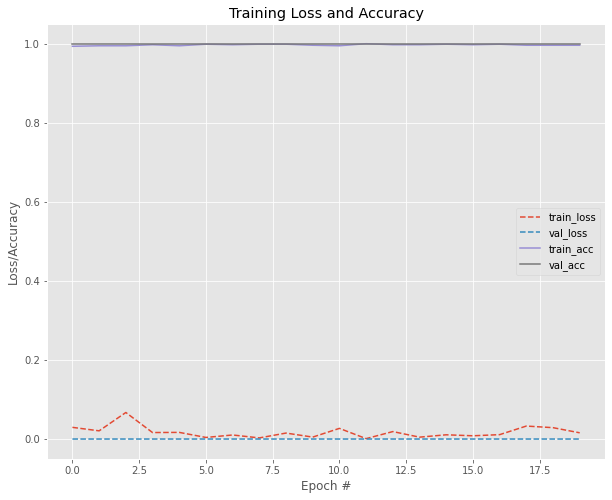

In [56]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [57]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "Training Loss and Accuracy of the transfer learning with fine tuning": wandb.Image(fig),
    }
)

22-11-2022 01:17:50 Uploading figures


In [58]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [59]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
1/1 [==============================] - 1s 925ms/step
              precision    recall  f1-score   support

      Bengal       1.00      1.00      1.00         2
    Keeshond       1.00      1.00      1.00         4
Russian_blue       1.00      1.00      1.00         6
       boxer       1.00      1.00      1.00        12
         pug       1.00      1.00      1.00         8

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



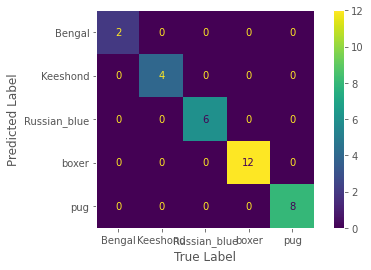

In [60]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [61]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix of the transfer learning with fine tuning": wandb.Image(fig_confusion_matrix),
    }
)

22-11-2022 01:18:19 Uploading figures


In [62]:
run.finish()

accuracy,▁▃▅▆▇▇▇▇████████████████████████████████
epoch,▁▁▂▂▃▄▄▅▅▆▇▇██▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▄▅▅▆▇▇█
loss,█▆▄▄▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇███████████████████████████████████
val_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CO2_Emissions of the transfer learning with feature extractor,0.00909
CO2_Emissions of the transfer learning with fine tuning,0.00759
CO2_Emissions of the transfer learning with fine tuning (head),0.00512
Count_Params of the transfer learning with feature extractor,23597957
Count_Params of the transfer learning with fine tuning,49279365
Count_Params of the transfer learning with fine tuning (head),49279365
